## TE Connect CNN-LSTM Attempt

Author: Alexiy Buynitsky

Resources:
https://towardsdatascience.com/cnn-lstm-based-models-for-multiple-parallel-input-and-multi-step-forecast-6fe2172f7668

https://github.com/lkulowski/LSTM_encoder_decoder

https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/

TODO:
- Add baseline model using running averages as a comparison
- Add ways to control all paramters in global classes
- add cnn-lstm model
- Double check all data is added as training and testing split

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
from torchvision import datasets, transforms
import random as random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

## Data Prep

In [2]:


df = pd.read_csv("te_ai_cup_sales_forecasting_data.csv")
print("num rows:", len(df))
print("num cols:", df.shape[1])
df["year_week_ordered"] = df['fiscal_year_historical']*100 + \
    df['fiscal_week_historical']
df.sort_values(by=['fiscal_year_historical'] +
               ['fiscal_week_historical'], inplace=True)
df.reset_index(drop=True, inplace=True)
u_prod_code = df["product_line_code"].unique()
print(u_prod_code)
df["Price"] = df["sales_amount"]/df["sales_quantity"]
display(df.head(10))


num rows: 522698
num cols: 10
['E77' '053' '202' 'ABP' 'AC5' '607' 'AC6' '088' 'H98' 'DK4' 'N65' '372'
 'FG2' '251' '208' 'F49' 'H90' 'J67' 'J63' '073' '351' '050' 'K70' '301'
 'J37' 'A13' 'AQ9' '038' '025' '440' '481' '145' '230' 'K85' 'JB3' '547'
 '239' '912' '281' '231' 'LT0' '214' 'JF1' 'A28' '567' 'B91' '438' '430'
 'K00' 'J89' 'E31' 'Z27' '291' 'Z83' 'G60' '518' '472' 'F52' 'G59' '042'
 'N09' '323' '715' 'A05' '072' '397' '957' 'J25' '217' '014' '224' 'G49'
 '344' '207' 'AP2' '002' '529' '077' 'E82' '835' 'LV4' '728' '890' '032'
 '757' 'E79' '097' 'Z34' '057' 'F38' 'Z43' 'F83' 'F82' 'G74' 'AG7' '685'
 '977' '009' 'A92' '712' 'F50' '001' 'JH4' '402' '124' '023' '961' '313'
 'G61' 'F48' '056' 'G41' '232' '766' '519' 'J12' '243' 'LV1' '204' 'F41'
 '450' '516' 'W02' 'Z40' '080' '289' '036' '394' '150' 'JC1' 'J46' 'AH8'
 '046' 'F40' '716' 'G30' 'B77' 'JJ4' 'C19' 'DA8' 'K80' '327' 'E83' 'F46'
 '350' 'J45' '748' 'Z77' 'N73' '914' 'JE2' '085' 'JC3' '312' '127' 'J96'
 '760' '076' 'K18' 'N

,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
0,2015,1,1,1,Energy,EMEA,E77,LV/MV Surge Arresters,1641.00,126789.47,201501,77.263541
1,2015,1,1,1,Channel - Data and Devices,Asia Pacific & ANZ,053,Memory Sockets,14417.92,17379.52,201501,1.205411
2,2015,1,1,1,Channel - Industrial,EMEA,202,PLASTI-GRIP Terminals,142820.40,19666.38,201501,0.137700
3,2015,1,1,1,Industrial,Americas,ABP,Specific terminal blocks,14528.00,-12089.77,201501,-0.832170
4,2015,1,1,1,Data and Devices,EMEA,AC5,"Antennas, Custom Others",34400.00,30357.47,201501,0.882485
5,2015,1,1,1,Appliances,EMEA,607,DW-All Other Dual Wall,201134.00,99060.41,201501,0.492510
6,2015,1,1,1,Data and Devices,EMEA,AC6,"Antennas, Standard",1020.00,14178.82,201501,13.900804
7,2015,1,1,1,"Aerospace, Defense & Marine",Americas,088,G Series Products,22403.00,-11833.37,201501,-0.528205
8,2015,1,1,1,Industrial Commercial Transportation,Americas,H98,DTP,95563.00,82885.19,201501,0.867336
9,2015,1,1,1,Industrial,EMEA,DK4,Signal Proprietary,1894.00,16306.23,201501,8.609414


## Splitting the Data based on Specific Paramters

In [3]:
def get_raw_data(filtered_df, business_unit_group_name=None, company_region_name_level1=None, product_line_code=None):
    if business_unit_group_name is not None:
        filtered_df = filtered_df[filtered_df['business_unit_group_name']
                                  == business_unit_group_name]
    if company_region_name_level1 is not None:
        filtered_df = filtered_df[filtered_df['company_region_name_level_1']
                                  == company_region_name_level1]
    if product_line_code is not None:
        filtered_df = filtered_df[filtered_df['product_line_code']
                                  == product_line_code]

    if len(filtered_df) == 0:
        raise Exception("ERROR: empty dataset")
    return filtered_df

# raw_df = get_raw_data(df,company_region_name_level1= "EMEA")
raw_df = get_raw_data(df)
display(raw_df.head(10))


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
0,2015,1,1,1,Energy,EMEA,E77,LV/MV Surge Arresters,1641.00,126789.47,201501,77.263541
1,2015,1,1,1,Channel - Data and Devices,Asia Pacific & ANZ,053,Memory Sockets,14417.92,17379.52,201501,1.205411
2,2015,1,1,1,Channel - Industrial,EMEA,202,PLASTI-GRIP Terminals,142820.40,19666.38,201501,0.137700
3,2015,1,1,1,Industrial,Americas,ABP,Specific terminal blocks,14528.00,-12089.77,201501,-0.832170
4,2015,1,1,1,Data and Devices,EMEA,AC5,"Antennas, Custom Others",34400.00,30357.47,201501,0.882485
5,2015,1,1,1,Appliances,EMEA,607,DW-All Other Dual Wall,201134.00,99060.41,201501,0.492510
6,2015,1,1,1,Data and Devices,EMEA,AC6,"Antennas, Standard",1020.00,14178.82,201501,13.900804
7,2015,1,1,1,"Aerospace, Defense & Marine",Americas,088,G Series Products,22403.00,-11833.37,201501,-0.528205
8,2015,1,1,1,Industrial Commercial Transportation,Americas,H98,DTP,95563.00,82885.19,201501,0.867336
9,2015,1,1,1,Industrial,EMEA,DK4,Signal Proprietary,1894.00,16306.23,201501,8.609414


In [4]:
def group_by_unique(local_df, product_line=False, business_unit=False, company_region=False):

    group_by_list = []
    if (product_line):
        group_by_list.append("product_line_code")
    if (company_region):
        group_by_list.append("company_region_name_level_1")
    if (business_unit):
        group_by_list.append("business_unit_group_name")
    grouped_df = local_df.groupby(group_by_list)
    print(len(grouped_df))
    return grouped_df


In [5]:
grouped_df = group_by_unique(
    df, product_line=True, business_unit=True, company_region=True)
count = 0
for name, group in grouped_df:
    print(name)
    print(len(group))
    display(group.head(10))
    # display(group.head())
    count = count+1
    if count == 5:
        break


1339
('001', 'Asia Pacific & ANZ', 'Channel - Industrial')
418


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
108,2015,1,1,1,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,305278.80,33869.70,201501,0.110947
1299,2015,1,1,2,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,396862.44,44030.61,201502,0.110947
2484,2015,1,1,3,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,396862.44,44030.61,201503,0.110947
3699,2015,1,1,4,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,427390.32,47417.58,201504,0.110947
5763,2015,1,2,5,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,317301.14,43076.34,201505,0.135759
6981,2015,1,2,6,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,367401.32,49877.86,201506,0.135759
8179,2015,1,2,7,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,334001.20,45343.51,201507,0.135759
9390,2015,1,2,8,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,334001.20,45343.51,201508,0.135759
10605,2015,1,2,9,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,317301.14,43076.34,201509,0.135759
10902,2015,1,3,10,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,152336.00,35769.20,201510,0.234805


('001', 'Asia Pacific & ANZ', 'Industrial')
415


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
1043,2015,1,1,1,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,513152.0,76599.06,201501,0.149272
2258,2015,1,1,2,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,179474.0,30120.36,201502,0.167826
3515,2015,1,1,3,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,473700.0,42911.32,201503,0.090588
4608,2015,1,1,4,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,331975.0,17220.96,201504,0.051874
5090,2015,1,2,5,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,515725.0,55527.06,201505,0.107668
6667,2015,1,2,6,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,265937.0,74272.87,201506,0.279287
7636,2015,1,2,7,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,399465.0,96394.33,201507,0.241309
8485,2015,1,2,8,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,713300.0,52651.69,201508,0.073814
10715,2015,1,2,9,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,94396.0,46691.94,201509,0.494639
11456,2015,1,3,10,Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,156210.0,63392.99,201510,0.405819


('002', 'Americas', 'Channel - Industrial')
418


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
696,2015,1,1,1,Channel - Industrial,Americas,002,AMPMODU System 50,17098.00,30641.84,201501,1.792130
1894,2015,1,1,2,Channel - Industrial,Americas,002,AMPMODU System 50,22227.40,39834.40,201502,1.792130
3117,2015,1,1,3,Channel - Industrial,Americas,002,AMPMODU System 50,22227.40,39834.40,201503,1.792130
4288,2015,1,1,4,Channel - Industrial,Americas,002,AMPMODU System 50,23937.20,42898.58,201504,1.792130
5765,2015,1,2,5,Channel - Industrial,Americas,002,AMPMODU System 50,18016.37,36681.44,201505,2.036006
6983,2015,1,2,6,Channel - Industrial,Americas,002,AMPMODU System 50,20861.06,42473.25,201506,2.036006
8181,2015,1,2,7,Channel - Industrial,Americas,002,AMPMODU System 50,18964.60,38612.04,201507,2.036006
9392,2015,1,2,8,Channel - Industrial,Americas,002,AMPMODU System 50,18964.60,38612.04,201508,2.036006
10607,2015,1,2,9,Channel - Industrial,Americas,002,AMPMODU System 50,18016.37,36681.44,201509,2.036006
11890,2015,1,3,10,Channel - Industrial,Americas,002,AMPMODU System 50,24050.75,42878.82,201510,1.782848


('002', 'Americas', 'Industrial')
418


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
176,2015,1,1,1,Industrial,Americas,002,AMPMODU System 50,38784.0,48835.78,201501,1.259173
1679,2015,1,1,2,Industrial,Americas,002,AMPMODU System 50,60028.0,80518.56,201502,1.341350
3127,2015,1,1,3,Industrial,Americas,002,AMPMODU System 50,28550.0,38572.70,201503,1.351058
4002,2015,1,1,4,Industrial,Americas,002,AMPMODU System 50,52851.0,71123.96,201504,1.345745
5857,2015,1,2,5,Industrial,Americas,002,AMPMODU System 50,40697.0,41301.96,201505,1.014865
6518,2015,1,2,6,Industrial,Americas,002,AMPMODU System 50,31013.0,49768.85,201506,1.604774
8112,2015,1,2,7,Industrial,Americas,002,AMPMODU System 50,62659.0,101831.63,201507,1.625172
8956,2015,1,2,8,Industrial,Americas,002,AMPMODU System 50,38068.0,55429.44,201508,1.456064
10581,2015,1,2,9,Industrial,Americas,002,AMPMODU System 50,16364.0,24064.56,201509,1.470579
11004,2015,1,3,10,Industrial,Americas,002,AMPMODU System 50,35642.0,66100.95,201510,1.854580


('002', 'Asia Pacific & ANZ', 'Channel - Industrial')
418


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
563,2015,1,1,1,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,3875.80,6389.06,201501,1.648449
1763,2015,1,1,2,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,5038.54,8305.78,201502,1.648450
2981,2015,1,1,3,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,5038.54,8305.78,201503,1.648450
4153,2015,1,1,4,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,5426.12,8944.69,201504,1.648450
5426,2015,1,2,5,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,8444.93,13086.15,201505,1.549587
6678,2015,1,2,6,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,9778.34,15152.39,201506,1.549587
7881,2015,1,2,7,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,8889.40,13774.90,201507,1.549587
9089,2015,1,2,8,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,8889.40,13774.90,201508,1.549587
10264,2015,1,2,9,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,8444.93,13086.15,201509,1.549587
10836,2015,1,3,10,Channel - Industrial,Asia Pacific & ANZ,002,AMPMODU System 50,10031.25,15437.74,201510,1.538965


In [6]:
groups = [grouped_df.get_group(x) for x in grouped_df.groups]


## Preparing the Data for Training

In [16]:
class Data_Prep:
    # must contain each one of these labels
    data_filter = ["Asia Pacific & ANZ","Channel - Industrial"]
    #data_filter = ["Asia Pacific & ANZ"]
    # collumns of interest
    input_data_cols = ["sales_amount", "sales_quantity", "Price"] # add features to end to make itself predict the output col - lstm not limit to 1 feature
    # input_data_cols = ["sales_amount"]
    output_data_cols = ["sales_amount"]
    output_data_features = len(output_data_cols)
    input_data_features = len(input_data_cols)
    percent = 0.8 # test-train split percentage
    lookback = 20 # number of units used to make prediction
    predict = 5 # number of units that will be predicted
    check_dl = False # debugging purposes for checking if dataloader works

In [8]:

for group in groups:
    #TODO: uncommented this line 
    #df2 = group[group.duplicated('year_week_ordered')]
    # duplicate = df[df.duplicated('City')]
    display(group.head(5))
    break


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
108,2015,1,1,1,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,305278.80,33869.70,201501,0.110947
1299,2015,1,1,2,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,396862.44,44030.61,201502,0.110947
2484,2015,1,1,3,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,396862.44,44030.61,201503,0.110947
3699,2015,1,1,4,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,427390.32,47417.58,201504,0.110947
5763,2015,1,2,5,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,317301.14,43076.34,201505,0.135759


Note:
Found that there were some outlier values - might want to remove them and then interpolate on them depending on the results

In [9]:

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"

    df.dropna(inplace=True)
    print("new len:", len(df.columns))
    return df

# TODO: need to implement removal of outliers
def removeOutliers(group, col):
    return group


In [10]:
def key_filter_match(name,data_filter):
    if len(data_filter)==0:
        return True
    for e in data_filter:
        if not e in name:
            return False
    return True

def transform_norm_rem_out(grouped_df, input_data_cols,output_data_cols,data_filter):
    transformed_data = {}
    reg_data = {}
    input_transformations = {}
    output_transformations = {}
    display_once = True
    count = 0
    data_cols = input_data_cols + list(set(output_data_cols) - set(input_data_cols))
    print(input_data_cols)
    print(output_data_cols)
    for name, group in grouped_df:
        if key_filter_match(name,data_filter):
            for col in data_cols:

                if len(group[col]) == 0:
                    raise Exception("Collumn does not exist!")
                # removeOutliers(group[col],col)
                # interpolate the mission values

            scalar1 = MinMaxScaler()
            scalar2 = MinMaxScaler()
            # group[data_cols] = clean_dataset(group[data_cols]) # this line
            for i in range(0, len(group.columns)):
                group.iloc[:, i].interpolate(inplace=True)
            group = group.replace((np.inf, -np.inf, np.nan),
                                0).reset_index(drop=True)
     
            reg_data[name] = group.copy()
            input_transformations[name] = scalar1.fit(group[input_data_cols])
            output_transformations[name] = scalar2.fit(group[output_data_cols])
            group[data_cols] = scalar1.fit_transform(group[input_data_cols])
            transformed_data[name] = group
            if display_once:
                print("\n")
                print(name)
                display(transformed_data[name])
                display_once = False
            count += 1
            print(count, "/", len(grouped_df), end="\r")

    

    return reg_data, transformed_data, input_transformations,output_transformations

In [11]:
reg_data,transformed_data, input_transformations,output_transformations = transform_norm_rem_out(
    grouped_df, Data_Prep.input_data_cols,Data_Prep.output_data_cols, Data_Prep.data_filter)


['sales_amount', 'sales_quantity', 'Price']
['sales_amount']


('001', 'Asia Pacific & ANZ', 'Channel - Industrial')


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
0,2015,1,1,1,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.307948,0.093309,201501,0.018802
1,2015,1,1,2,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.409376,0.129342,201502,0.018802
2,2015,1,1,3,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.409376,0.129342,201503,0.018802
3,2015,1,1,4,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.443185,0.141354,201504,0.018802
4,2015,1,2,5,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.321262,0.125958,201505,0.060800
...,...,...,...,...,...,...,...,...,...,...,...,...
413,2022,4,12,49,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.782539,0.437068,202249,0.132730
414,2022,4,12,50,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.872838,0.488609,202250,0.132730
415,2022,4,12,51,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.782539,0.437068,202251,0.132730
416,2022,4,12,52,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.963136,0.540150,202252,0.132730


This was a check to make sure that transforms were being saved - they were

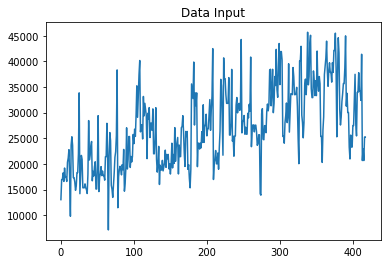

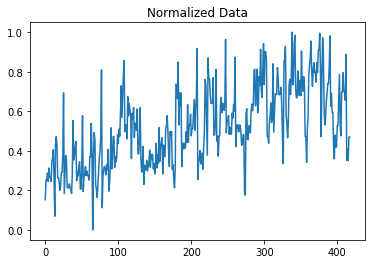

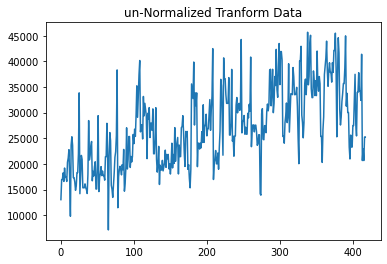

In [12]:
k = '202', 'Asia Pacific & ANZ', 'Channel - Industrial'

#display(transformed_data[k])
plt.title("Data Input")
plt.plot(reg_data[k]['sales_amount'])
plt.show()
plt.title("Normalized Data")
plt.plot(transformed_data[k]['sales_amount'])
plt.show()
transform = output_transformations[k]
plt.title("un-Normalized Tranform Data")
inv_t_data = transform.inverse_transform(transformed_data[k][Data_Prep.output_data_cols])
#display(inv_t_data)
#print(np.asarray(inv_t_data).shape)
plt.plot(inv_t_data)
plt.show()
# shape is __ x 3

In [13]:

def prep_data(data, past, future, input_data_cols,output_data_cols):
    x, y = list(), list()
    inp_data_arr = data[input_data_cols].to_numpy()
    out_data_arr = data[output_data_cols].to_numpy()
    for i in range(len(inp_data_arr)):
        lag_end = i+past
        forcast_end = lag_end+future
        if forcast_end > len(data):
            break
        x.append(inp_data_arr[i:lag_end])
        y.append(out_data_arr[lag_end:forcast_end])
    return np.array(x), np.array(y)


In [14]:

num_features = len(Data_Prep.input_data_cols)
show_sample = False
dict_train_data = {}
dict_valid_data = {}
all_valid_data = []
all_train_data = []
for key, group in transformed_data.items():
    split = (int)(len(group)*Data_Prep.percent)# TODO: check the test train split
    train_data = group[0:split]
    valid_data = group[split:]
    x_train, x_test = prep_data(train_data, Data_Prep.lookback, Data_Prep.predict, Data_Prep.input_data_cols,Data_Prep.output_data_cols)
    y_train, y_test = prep_data(valid_data, Data_Prep.lookback, Data_Prep.predict, Data_Prep.input_data_cols,Data_Prep.output_data_cols)

    if show_sample:
        print("train:")
        print(x_train.shape)
        print(x_train[0])
        print(x_test.shape)
        print(x_test[0])
        print("valid:")
        print(y_train.shape)
        print(y_train[0])
        print(y_test.shape)
        print(y_test[0])
        show_sample = False
    all_train_data.append((x_train, x_test))
    all_valid_data.append((y_train, y_test))
    dict_valid_data[key] = (x_train, x_test)
    dict_train_data[key] = (y_train, y_test)

In [15]:
all_valid_data = np.array(all_valid_data,dtype=object)
all_train_data = np.array(all_train_data,dtype=object)
print(len(all_valid_data))
print(len(all_train_data))

print(all_valid_data.shape)
print(all_train_data.shape)

def get_all_data_arr(all_data):
    tr = []
    te= []
    for i in range(len(all_data)):
        x_tr = all_data[i][0]
        x_te = all_data[i][1]
        for j in range(len(x_tr)):
            tr.append(x_tr[j])
            te.append(x_te[j])
    return np.array(tr),np.array(te)

train_y,test_y = get_all_data_arr(all_valid_data)
train_x,test_x = get_all_data_arr(all_train_data)

print("y train shape:",train_y.shape)
print("y test shape:",test_y.shape)

print("x train shape:",train_x.shape)
print("x test shape:",test_x.shape)


56
56
(56, 2)
(56, 2)
y train shape: (3336, 20, 3)
y test shape: (3336, 5, 1)
x train shape: (17261, 20, 3)
x test shape: (17261, 5, 1)


## Model Info

In [19]:
class Model_Info:
    batch_size = 2048
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    count_print_batch = 4 # the number of times training loss printed for each epoch
    learning_rate = 5e-3
    epochs = 10_000
    model_save_path = "/home/abuynits/Projects/TE_Connect/savedModels/"
    save_model = False
    hidden_size = 64 # the number of features in the stacked lstm
    enc_drop = 0.
    dec_drop = 0.
    num_layers = 32
    train_prediction = 'recursive'
    display_batch_train_data = False
    
lstm_inp_size = Data_Prep.input_data_features # number of input features in lstm
lstm_out_size = Data_Prep.output_data_features # number of output features in lstm
lstm_hidden_count = 128 # number of lstm cells
lstm_dropout = 0. # dropout
lstm_layer_count = 2 # number of layers in lstm cell
lstm_input_seq_len = Data_Prep.lookback # length of input sequence to LSTM
lstm_verbose = False

In [21]:
def print_model(model):
  sum = 0
  print(model)
  for param in model.parameters():
      if param.requires_grad:
          sum += param.numel()
  print("total trainable parameters:",sum)

In [20]:
def createList(l,h):
    return [i for i in range(l,h)]

def print_data_loader(inp_seq,out_seq,num_print):
    for i in range(num_print):
        print(" Input seq:",inp_seq[i])
        print(" Out seq:",out_seq[i])

def check_data_loader(dl_train_item,dl_test_item):
    #print(dl_train_item.shape)
    #print(dl_test_item.shape)
    train_low = 0
    train_high = len(dl_train_item[0])
    test_low = 0
    test_high = len(dl_test_item[0])
    for seq in dl_train_item:
        plt.plot(createList(train_low,train_high),seq.squeeze(),color='blue')
        train_low+=1
        train_high+=1
    plt.title("train plot")
    plt.show()
    for seq in dl_test_item:
        if len(seq) == 1:
            #print(seq.shape)
            #print(createList(test_low,test_high))
            plt.scatter(createList(test_low,test_high),seq)
        else:
            plt.plot(createList(test_low,test_high),seq.squeeze())
        test_low+=1
        test_high+=1
    plt.title("test plot")
    plt.show()

    
class finance_data_set(Dataset):
    def __init__(self, trainDT, testDT):
        super().__init__()
        self.train = trainDT
        self.test = testDT
        self.data_len = len(trainDT)

    def __len__(self):
        return self.data_len

    def __getitem__(self, i):
        tr = torch.from_numpy(self.train[i]).float()
        te = torch.from_numpy(self.test[i]).float()
        return (tr,te)


# train_ds = finance_data_set(x_train, x_test)
# test_ds = finance_data_set(y_train, y_test)

train_ds = finance_data_set(train_x, test_x)
test_ds = finance_data_set(train_y, test_y)
print(x_train.shape)
print(all_train_data[1][0].shape)
#train_ds = finance_data_set(all_train_data[0], all_train_data[1])
#test_ds = finance_data_set(all_valid_data[0], all_valid_data[1])

test_dl = DataLoader(test_ds, batch_size=Model_Info.batch_size, shuffle=True)
print(f"batches in test dl: {len(test_dl)}")
train_dl = DataLoader(train_ds, batch_size=Model_Info.batch_size, shuffle=False)
print(f"batches in train dl: {len(train_dl)}")


if Data_Prep.check_dl:
    check_data_loader(next(iter(train_dl))[0],next(iter(train_dl))[1])
print_data_loader(next(iter(train_dl))[0],next(iter(train_dl))[1],2)
print_data_loader(next(iter(train_dl))[0],next(iter(train_dl))[1],2)
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)
print(next(iter(test_dl))[0].shape)
print(next(iter(test_dl))[1].shape)

 #         

(310, 20, 3)
(310, 20, 3)
batches in test dl: 2
batches in train dl: 9
 Input seq: tensor([[0.0933, 0.3079, 0.0188],
        [0.1293, 0.4094, 0.0188],
        [0.1293, 0.4094, 0.0188],
        [0.1414, 0.4432, 0.0188],
        [0.1260, 0.3213, 0.0608],
        [0.1501, 0.3767, 0.0608],
        [0.1340, 0.3398, 0.0608],
        [0.1340, 0.3398, 0.0608],
        [0.1260, 0.3213, 0.0608],
        [0.1000, 0.1386, 0.2285],
        [0.1051, 0.1453, 0.2285],
        [0.1153, 0.1588, 0.2285],
        [0.0797, 0.1116, 0.2285],
        [0.0612, 0.1936, 0.0388],
        [0.1858, 0.5106, 0.0388],
        [0.2005, 0.5478, 0.0388],
        [0.1858, 0.5106, 0.0388],
        [0.1448, 0.4345, 0.0263],
        [0.1448, 0.4345, 0.0263],
        [0.1366, 0.4124, 0.0263]])
 Out seq: tensor([[0.1203],
        [0.1285],
        [0.1022],
        [0.1022],
        [0.1280]])
 Input seq: tensor([[0.1293, 0.4094, 0.0188],
        [0.1293, 0.4094, 0.0188],
        [0.1414, 0.4432, 0.0188],
        [0.1260, 0.32

In [23]:
seq2seq_verbose = False
print_once = False

In [51]:
class encoder_lstm(nn.Module):
  def __init__(self, inp_size, hid_size, dropout, layer_count):
        super(encoder_lstm, self).__init__()
        self._input_size = inp_size  # number of input features
        self._hidden_size = hid_size  # number of features in hidden state
        self._layer_count = layer_count  # number of lstm cells
        self._dropout = dropout # dropout for lstm

        self._lstm = nn.LSTM(input_size=self._input_size,
                            hidden_size=self._hidden_size,
                            num_layers=self._layer_count, 
                            dropout=self._dropout)
        
        self._drop = nn.Dropout(dropout)
  def forward(self,x):
    # input shape: (seq_len, count units in batch, input size)
    if seq2seq_verbose:
      print("enc: inp shape",x.shape)
    out,(self.hn,self.cn) = self._lstm(x)
    if seq2seq_verbose:
      #print("enc: out shape",out.shape)
      print("enc: hn shape",self.hn.shape)

    return out.to(Model_Info.device), (self.hn,self.cn)

  def init_hidden(self,batch_size):
    h_0 = torch.randn(self._layer_count,batch_size,self._hidden_size).requires_grad_().to(Model_Info.device)
    c_0 = torch.randn(self._layer_count,batch_size,self._hidden_size).requires_grad_().to(Model_Info.device)
    return (h_0,c_0)
class decoder_lstm(nn.Module):
  def __init__(self,inp_size,out_size, hid_size, layer_count,drop):
    super(decoder_lstm,self).__init__()
    self._inp_feature_size = inp_size # number of input features
    self._out_feature_size = out_size # number of output features
    self._hid_size = hid_size # size of lstm cells
    self._layer_count = layer_count # number of hidden lstm cells
    self._dropout = drop # dropout

    self._lstm = nn.LSTM(input_size=self._inp_feature_size, 
                        hidden_size = self._hid_size, 
                        num_layers = self._layer_count,
                        dropout=self._dropout)
    
    self._l_in = nn.Linear(self._hid_size,self._inp_feature_size)
    self._l_out = nn.Linear(self._hid_size,self._out_feature_size)

  def forward(self,x,enc_hidden_states):
    # x: 2d - the last input time step so (batches,input_features)
    # enc_hidden_states: the last hidden decoder time step
    if seq2seq_verbose:
      print("dec: inp shape",x.shape)
    #lstm_out, (hn, cn) = self._lstm(x,enc_hidden_states)
    lstm_out, (self.hn,self.cn) = self._lstm(x.unsqueeze(0),enc_hidden_states)
    if seq2seq_verbose:
      print("dec: lstm out shape",lstm_out.shape)
      print("dec: hn shape",self.hn[0].shape)
    
    output = self._l_in(lstm_out.squeeze(0)) # squeeze becasue added dimenion to x
    final_output = self._l_out(lstm_out.squeeze(0))

    if seq2seq_verbose:
      print("dec: output shape", output.shape)
      print("dec: final output shape", final_output.shape)
      print("dec: final hn shape", self.hn.shape)
    return final_output, output, (self.hn,self.cn)

class seq2seq(nn.Module):
  def __init__(self,inp_size=Data_Prep.input_data_features,out_size = Data_Prep.output_data_features,hid_size=lstm_hidden_count,layer_count=lstm_layer_count,dropout=lstm_dropout):
    super(seq2seq,self).__init__()
    self._inp_size = inp_size
    self._hid_size = hid_size
    self._layer_count = layer_count
    self._dropout = dropout
    self._out_size = out_size
    
    self._enc = encoder_lstm(inp_size=self._inp_size, hid_size=self._hid_size,dropout=self._dropout,layer_count=self._layer_count)
    self._dec = decoder_lstm(inp_size=self._inp_size, out_size = self._out_size, hid_size=self._hid_size,drop=self._dropout,layer_count=self._layer_count)

    print_model(self)
    self.model_name = "seq2seq"


  def forward(self,inp):
    outputs = torch.zeros(Data_Prep.predict,inp.size(1),self._out_size)
    enc_hidden = self._enc.init_hidden(inp.size(1))

    if seq2seq_verbose:
      print("============")
      print("seq2seq: input",inp.shape)
      print("seq2seq: outputs",outputs.shape)
      print("seq2seq: hn",enc_hidden[0].shape)

    enc_out,enc_hidden = self._enc(inp)

    if seq2seq_verbose:
      print("seq2seq: enc_out",enc_out.shape)
      print("seq2seq: enc_hidden",enc_hidden[0].shape)

    dec_inp = inp[-1,:,:] # get the last element
    dec_hidden = enc_hidden # enc hidden is the last hidden state of the elements

    if seq2seq_verbose:
      print("seq2seq: dec_inp",dec_inp.shape)
      print("seq2seq: dec_hidden", dec_hidden[0].shape)

    for p in range(Data_Prep.predict):
      final_dec_out,dec_out,dec_hidden = self._dec(dec_inp,dec_hidden)
      if seq2seq_verbose:
        print(" seq2seq: final_dec_out",final_dec_out.shape)
        print(" seq2seq: dec_out", dec_out.shape)
        print(" seq2seq: dec_hidden hn",dec_hidden[0].shape)
      outputs[p] = final_dec_out
      dec_inp = dec_out
    if seq2seq_verbose:
      print("seq2seq: outputs",outputs.shape)
    if print_once:
      print(outputs)
    #print(outputs)
    return outputs.to(Model_Info.device)


  def predict_seq(self,x):
    x = x.unsqueeze(1) # add in dim of 1
    (hn,cn) = self._enc.init_hidden(1)
    enc_out, (hn,cn) = self._enc(x)
  
    outputs = torch.zeros(Data_Prep.predict,Data_Prep.output_data_features)
    dec_inp = x[-1,:,:] # get the last element
    dec_hidden = (hn,cn) # enc hidden is the last hidden state of the elements

    for p in range(Data_Prep.predict):
      final_dec_out,dec_out,dec_hidden = self._dec(dec_inp,dec_hidden)
      if seq2seq_verbose:
        print(" seq2seq: final_dec_out",final_dec_out.shape)
        print(" seq2seq: dec_out", dec_out.shape)
        print(" seq2seq: dec_hidden hn",dec_hidden[0].shape)
      outputs[p] = final_dec_out
      dec_inp = dec_out
    if seq2seq_verbose:
      print("seq2seq: outputs",outputs.shape)
    return outputs

class multi_input_lstm(nn.Module):


In [52]:
class lstm(nn.Module):
  def __init__(self,inp_size=lstm_inp_size,out_size=lstm_out_size,hidden_size=lstm_hidden_count,layer_count=lstm_layer_count,seq_len=lstm_input_seq_len,dropout=0):
    super(lstm,self).__init__()
    self.model_name = "lstm"
    self.inp_size = inp_size
    self.out_size = out_size
    self.hid_size = hidden_size
    self.layer_count = layer_count
    self.seq_len = seq_len
    self.drop = dropout
    
    self.lstm = nn.LSTM(input_size=self.inp_size, hidden_size=self.hid_size, num_layers=self.layer_count, batch_first=True, dropout=self.drop)

    self.fc = nn.Linear(hidden_size,out_size)

    print_model(self)

  def forward(self,inp):
    if lstm_verbose:
      print("inp shape:",inp.shape) 
      print("hn shape:",hn.shape)
      print("cn shape:",cn.shape)
    (hn,cn) = self.init_hidden(inp.size(0))
    # try with (hn,cn)
    lstm_out,hidden = self.lstm(inp,(hn,cn))
    out = self.fc(hn[0]).flatten()
    if lstm_verbose:
      print("hn[0] shape:", hn[0].shape)
      print("out lstm shape:", out.shape)
    return out

  def init_hidden(self,b_size):
    h_0 = torch.randn(self.layer_count, b_size, self.hid_size).to(Model_Info.device) # lstm cells, batches, hidden features
    c_0 = torch.randn(self.layer_count, b_size, self.hid_size).to(Model_Info.device) # lstm cells, batches, hidden features
    return(h_0,c_0)


## Training Loop

In [53]:
from torch.optim.lr_scheduler import ExponentialLR
train_loss = [] # track training loss
valid_loss = [] # track validation loss
learning_rate = 0.001 # the learning rate
n_epochs = 1000 # number of epochs
GAMMA = 0.999999
#model = lstm().to(device) # TODO create the model
model = seq2seq().to(Model_Info.device)
model_name = model.model_name

print(model_name)
loss_func = nn.MSELoss()
optim = optimizer.Adam(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optim, gamma=GAMMA)

seq2seq(
  (_enc): encoder_lstm(
    (_lstm): LSTM(3, 128, num_layers=2)
    (_drop): Dropout(p=0.0, inplace=False)
  )
  (_dec): decoder_lstm(
    (_lstm): LSTM(3, 128, num_layers=2)
    (_l_in): Linear(in_features=128, out_features=3, bias=True)
    (_l_out): Linear(in_features=128, out_features=1, bias=True)
  )
)
total trainable parameters: 400900
seq2seq


In [54]:
num_epochs_run = 0
def train_epoch(dl,epoch):
  print_once = True
  model.train(True)

  epoch_train_loss = 0.
  # loop over training batches
  times_run = 0

  for i, (x,y) in enumerate(dl):
    optim.zero_grad() # zero gradients
    x= x.to(Model_Info.device)
    y= y.to(Model_Info.device)

    if model_name == "seq2seq":
      x = x.swapaxes(0, 1) # want to put data in (seq, batches,num features)
      y = y.swapaxes(0, 1)
    model_out = model.forward(x)

    # squeeze the tensors to account for 1 dim sizes
    model_out = model_out.squeeze()
    y = y.squeeze()
    
    loss = loss_func(model_out,y)
    epoch_train_loss += loss.item()*x.size(0)

    times_run += x.size(0)

    # compute the loss
    loss.backward()
    # step the optimizer
    optim.step()
  
  return epoch_train_loss/times_run

def test_epoch(dl,epoch):
  model.train(False)
  epoch_test_loss = 0.
  times_run = 0
  # loop over testing batches
  for i, (x,y) in enumerate(dl):
    if model_name == "seq2seq":
      x = x.swapaxes(0, 1).to(Model_Info.device) # want to put data in (seq, batches,num features)
      y = y.swapaxes(0, 1).to(Model_Info.device)
    model_out = model(x)
    # squeeze tensors to account for 1 dim sizes
    model_out = model_out.squeeze()
    y = y.squeeze()

    loss = loss_func(model_out,y)
    epoch_test_loss += loss.item()*x.size(0)
    times_run += x.size(0)

  return epoch_test_loss/times_run


for e in range(n_epochs):
  avg_train_loss = train_epoch(train_dl,e)
  avg_valid_epoch = test_epoch(test_dl,e)
  num_epochs_run += 1
  train_loss.append(avg_train_loss)
  valid_loss.append(avg_valid_epoch)
  scheduler.step()
  print(f"epoch {e}: avg train loss: {avg_train_loss} avg val loss: {avg_valid_epoch}")

epoch 0: avg train loss: 0.04737595199710793 avg val loss: 0.05921543389558792
epoch 1: avg train loss: 0.025751818385389116 avg val loss: 0.08414799347519875
epoch 2: avg train loss: 0.027241028638349638 avg val loss: 0.06775118410587311
epoch 3: avg train loss: 0.02433567949467235 avg val loss: 0.048677900806069374


KeyboardInterrupt: 

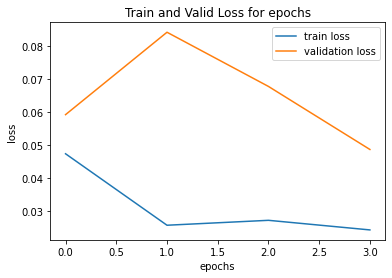

In [55]:
plt.plot(range(0, len(train_loss)), train_loss, label="train loss")
plt.plot(range(0, len(train_loss)), valid_loss, label="validation loss")
plt.legend()
plt.title("Train and Valid Loss for epochs")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [49]:
def predict_tensor_seq_to_seq(model: seq2seq, inp_tensor, target_len: int):
    """predicts the output for a specific input

    Args:
        model (seq2seq_lstm): the model
        inp_tensor (tensor): input tensor that is already normalized
        target_len (int): the target prediction length

    Returns:
        numpy array of outputs: the predicted seq for the specifed price
    """
    inp_tensor = inp_tensor.unsqueeze(1)  # add in batch size of 1
    model.train(False)
    enc_out, enc_hidden = model.enc(inp_tensor)

    outputs = torch.zeros(target_len, inp_tensor.shape[2])
    dec_inp = inp_tensor[-1, :, :]
    dec_hidden = enc_hidden

    for t in range(target_len):
        dec_out, dec_hidden = model.dec(dec_inp, dec_hidden)
        outputs[t] = dec_out.squeeze(0)  # collapse the 1 batch size
        dec_inp = dec_out  # move over the input
    np_out = outputs.detach().numpy()
    return np_out


attempts to predict all data points available - regardless of forcast and prediction length

In [70]:
predict_all_forcast = True
predict_model_focast = True

('001', 'Asia Pacific & ANZ', 'Channel - Industrial')
(394, 20, 3)
(394, 5, 1)


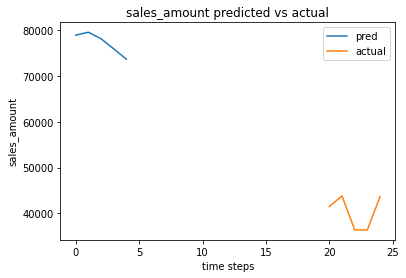

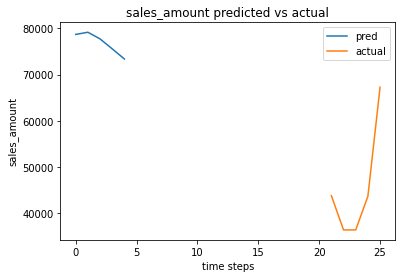

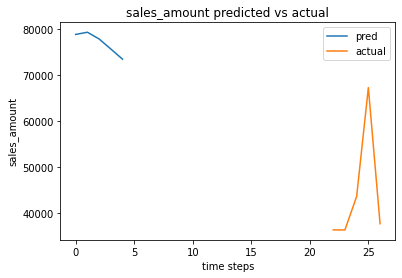

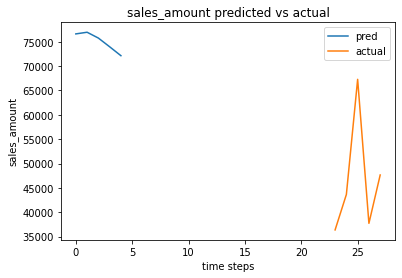

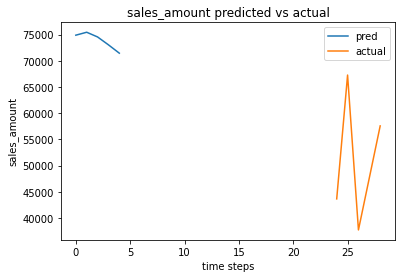

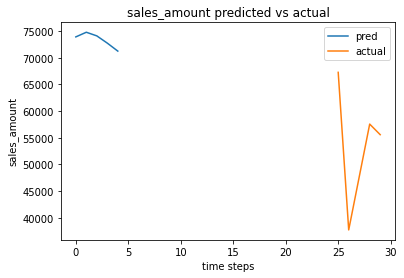

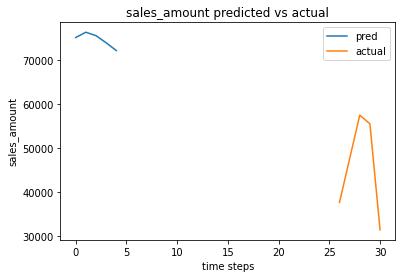

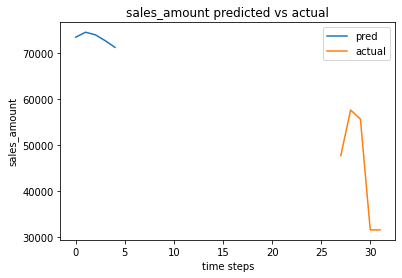

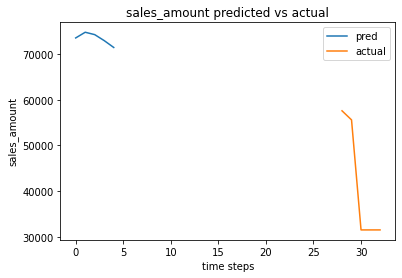

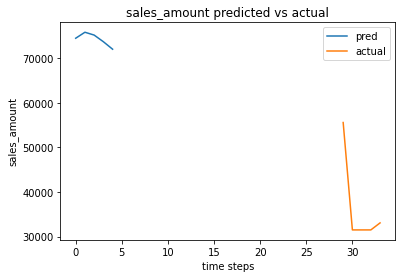

KeyboardInterrupt: 

In [71]:
for key, val in enumerate(transformed_data):
    # print(val)
    x, y = prep_data(
        transformed_data[val], Data_Prep.lookback, Data_Prep.predict, Data_Prep.input_data_cols, Data_Prep.output_data_cols)
    print(val)
    print(x.shape)
    print(y.shape)
    index_graphing = 0
    
    all_pred_data = []
    all_actual_data = []
    verbose = False
    all_actual_data= np.squeeze(output_transformations[val].inverse_transform(transformed_data[val][Data_Prep.output_data_cols])[0:len(x)])
    # x_axis = np.array(transformed_data[val]["year_week_ordered"][i+len(x[1]):i+len(x[1])+Data_Prep.predict])
    for i in range(len(x)):
        
        model_inp = torch.from_numpy(x[i]).float().to(Model_Info.device)
        
        #print(model_inp.shape)
        if model_name == "basic_lstm":
            
            pred = model(model_inp[None, :])
            pred = torch.unsqueeze(pred,1)
        else:
            #pred = predict_tensor_seq_to_seq(model, model_inp, Data_Prep.predict)
            pred = model.predict_seq(model_inp)
        # print(pred)
        # print("pred shape:", pred.shape)
        # print(output_transformations[val])
        pred_inv_t = output_transformations[val].inverse_transform(pred.detach().cpu())
        #print("pred inv shape:", pred_inv_t.shape)
        
        
        actual_in_t = reg_data[val]["sales_amount"][i + len(x[1]):i+len(x[1])+Data_Prep.predict]

        all_pred_data.append(np.squeeze(pred_inv_t,1)[0])
        #all_actual_data.append(actual_in_t)
        #print(actual_in_t.shape)
        if verbose:
            print("actual pred data:", pred)
            print("actual pred data:",pred_inv_t)
            print("actual data:", actual_in_t)
            print("shape", y[i].shape)
            
        # plt.plot(x_axis, pred_inv_t.T[0], label="pred 0")
        # plt.plot(x_axis, input_transformations[val].inverse_transform(y[i]).T[0], label="act 0")
        # plt.plot(x_axis,pred_inv_t.T[1],label="pred 1")
        # plt.plot(x_axis,transformations[val].inverse_transform(y[i]).T[1],label = "act 1")
        # plt.plot(x_axis,pred_inv_t.T[2],label="pred 2")
        # plt.plot(x_axis,transformations[val].inverse_transform(y[i]).T[2],label = "act 2")
        if predict_model_focast:
            # TODO: fix the display for predicting the model forcast
            plt.plot(pred_inv_t, label="pred")
            plt.plot(actual_in_t, label="actual")
            plt.legend()
            plt.title(f"{Data_Prep.input_data_cols[index_graphing]} predicted vs actual")
            plt.ylabel(Data_Prep.input_data_cols[index_graphing])
            plt.xlabel("time steps")
            plt.show()
    if predict_all_forcast:
        plt.plot(all_pred_data, label="pred")
        plt.plot(all_actual_data, label="actual")
        plt.legend()
        plt.title(f"{Data_Prep.input_data_cols[index_graphing]} predicted vs actual")
        plt.ylabel(Data_Prep.input_data_cols[index_graphing])
        plt.xlabel("time steps")
        plt.show()

    # print(x.shape)
    # print(y.shape)
    # print(transformations[val])

In [100]:
data_filter = ['Channel - Industrial']
reg_data, transformed_data, input_transformations, output_transformations = transform_norm_rem_out(
    grouped_df, Data_Prep.input_data_cols, Data_Prep.output_data_cols, data_filter)


['sales_amount', 'sales_quantity', 'Price']
['sales_amount']


('001', 'Asia Pacific & ANZ', 'Channel - Industrial')


,fiscal_year_historical,fiscal_quarter_historical,fiscal_month_historical,fiscal_week_historical,business_unit_group_name,company_region_name_level_1,product_line_code,product_line_name,sales_quantity,sales_amount,year_week_ordered,Price
0,2015,1,1,1,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.307948,0.093309,201501,0.018802
1,2015,1,1,2,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.409376,0.129342,201502,0.018802
2,2015,1,1,3,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.409376,0.129342,201503,0.018802
3,2015,1,1,4,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.443185,0.141354,201504,0.018802
4,2015,1,2,5,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.321262,0.125958,201505,0.060800
...,...,...,...,...,...,...,...,...,...,...,...,...
413,2022,4,12,49,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.782539,0.437068,202249,0.132730
414,2022,4,12,50,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.872838,0.488609,202250,0.132730
415,2022,4,12,51,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.782539,0.437068,202251,0.132730
416,2022,4,12,52,Channel - Industrial,Asia Pacific & ANZ,001,Miscellaneous AMPMODU,0.963136,0.540150,202252,0.132730


In [104]:
loc_sales_amt = 0;
for key, val in enumerate(transformed_data):
    # print(val)
    x, y = prep_data(
        transformed_data[val], Data_Prep.lookback, Data_Prep.predict, Data_Prep.input_data_cols, Data_Prep.output_data_cols)
    print(x.shape)
    print(y.shape)
    index_graphing = 0
    
    all_pred_data = []
    all_actual_data = []
    verbose = False
    # x_axis = np.array(transformed_data[val]["year_week_ordered"][i+len(x[1]):i+len(x[1])+Data_Prep.predict])
    
    model_np_inp = x[0]
    for i in range(len(x)):
        #print(model_np_inp.shape)
        if i != 0:
            print(model_np_inp.shape)
            model_np_inp = np.append(model_np_inp, pred.detach().cpu(),axis = loc_sales_amt)
            print(model_np_inp.shape)
            model_np_inp[loc_sales_amt] = model_np_inp[loc_sales_amt][1:]
            print(model_np_inp.shape)
        #model_inp = torch.unsqueeze(torch.from_numpy(model_np_inp).float().to(Model_Info.device),1)
        #print("model np inp", model_np_inp.shape)
        #print("model_inp shape", model_inp.shape)
        if model_name == "basic_lstm":
            
            pred = model(model_inp[None, :])
            pred = torch.unsqueeze(pred,1)
        else:
            pred = predict_tensor_seq_to_seq(model, model_inp, Data_Prep.predict)
        #print(pred)
        #print("pred shape:", pred.shape)
        pred_inv_t = output_transformations[val].inverse_transform(pred.detach().cpu())
        #print("pred inv shape:", pred_inv_t.shape)
        
        
        actual_in_t = reg_data[val]["sales_amount"][i + len(x[1]):i+len(x[1])+Data_Prep.predict]

        all_pred_data.append(np.squeeze(pred_inv_t,1)[0])
        all_actual_data.append(actual_in_t)
        
        #print(actual_in_t.shape)
        if verbose:
            print("actual pred data:", pred)
            print("actual pred data:",pred_inv_t)
            print("actual data:", actual_in_t)
            print("shape", y[i].shape)
            
        #plt.plot(x_axis, pred_inv_t.T[0], label="pred 0")
        
        #plt.plot(x_axis, input_transformations[val].inverse_transform(y[i]).T[0], label="act 0")
        # plt.plot(x_axis,pred_inv_t.T[1],label="pred 1")
        # plt.plot(x_axis,transformations[val].inverse_transform(y[i]).T[1],label = "act 1")
        # plt.plot(x_axis,pred_inv_t.T[2],label="pred 2")
        # plt.plot(x_axis,transformations[val].inverse_transform(y[i]).T[2],label = "act 2")
    plt.plot(all_pred_data, label="pred")
    plt.plot(all_actual_data, label="actual")
    plt.legend()
    plt.title(f"{Data_Prep.input_data_cols[index_graphing]} predicted vs actual")
    plt.ylabel(Data_Prep.input_data_cols[index_graphing])
    plt.xlabel("batches")
    plt.show()

    # print(x.shape)
    # print(y.shape)
    # print(transformations[val])

(398, 20, 3)
(398, 1, 1)
(20, 3)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 1

In [83]:
for key, val in enumerate(transformed_data):
    # print(val)
    x, y = prep_data(
        transformed_data[val], Data_Prep.lookback, Data_Prep.predict, Data_Prep.input_data_cols, Data_Prep.output_data_cols)
    print(x.shape)
    print(y.shape)
    index_graphing = 0
    for i in range(len(x)):
        x_axis = np.array(
            transformed_data[val]["year_week_ordered"][i+len(x[1]):i+len(x[1])+Data_Prep.predict])
        model_inp = torch.from_numpy(x[i]).float().to(Model_Info.device)
        pred = predict_tensor(model, model_inp, Data_Prep.predict)
        print(pred)
        print("pred shape:", pred.shape)
        pred_inv_t = input_transformations[val].inverse_transform(pred)
        print("pred inv shape:", pred_inv_t.shape)
        print("x_axis shape:", x_axis.shape)
        actual_in_t = reg_data[val]["sales_amount"][i +
                                                    len(x[1]):i+len(x[1])+Data_Prep.predict]
        print(actual_in_t.shape)
        print("actual data:", actual_in_t)
        plt.plot(x_axis, pred_inv_t.T[0], label="pred 0")
        print("shape", y[i].shape)
        plt.plot(x_axis, input_transformations[val].inverse_transform(
            y[i]).T[0], label="act 0")
        # plt.plot(x_axis,pred_inv_t.T[1],label="pred 1")
        # plt.plot(x_axis,input_transformations[val].inverse_transform(y[i]).T[1],label = "act 1")
        # plt.plot(x_axis,pred_inv_t.T[2],label="pred 2")
        # plt.plot(x_axis,input_transformations[val].inverse_transform(y[i]).T[2],label = "act 2")

        plt.plot(x_axis, actual_in_t, label="actual")
        if i == 2:
            print("BREAKING")
            break
        plt.legend()
        plt.title(f"{input_data_cols[index_graphing]} predicted vs actual")
        plt.ylabel(input_data_cols[index_graphing])
        plt.xlabel("batches")
        plt.show()

    # print(x.shape)
    # print(y.shape)
    # print(input_transformations[val])


(398, 20, 3)
(398, 1, 1)


NameError: name 'predict_tensor' is not defined